Data Import

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.svm import SVR

In [3]:
data1_raw = pd.read_csv("F:\Protein-Sequence-Classification-Project\pdb_data_no_dups.csv")
data2_raw = pd.read_csv("F:\Protein-Sequence-Classification-Project\pdb_data_seq.csv")

data1 = data1_raw.copy()
data2 = data2_raw.copy()

Data Preprocessing

In [4]:
data1_feature = ['resolution','residueCount','structureMolecularWeight','densityMatthews','densityPercentSol','phValue','experimentalTechnique','macromoleculeType']
data1_year = data1['publicationYear']
data1_index = data1['structureId']
data1_label = data1['classification']

row1, col1 = data1.shape
row2, col2 = data2.shape

In [5]:
# dropping unnecessary columns
drop_column = []
for i in data1.columns:
    if i not in data1_feature:
        drop_column.append(i)

data1 = data1.drop(columns=drop_column)

In [6]:
# converting catagorical columns to numerical value
label_encoder = LabelEncoder()
label1 = label_encoder.fit_transform(data1['macromoleculeType'])
label1 = pd.DataFrame(label1, columns=['macromoleculeType_encoded'])
label2 = label_encoder.fit_transform(data1['experimentalTechnique'])
label2 = pd.DataFrame(label2, columns=['experimentalTechnique_encoded'])
data1 = data1.join(label1)
data1 = data1.join(label2)

data1 = data1.drop(columns=['macromoleculeType','experimentalTechnique'])       #dropping the catagorical columns
data1 

,residueCount,resolution,structureMolecularWeight,densityMatthews,densityPercentSol,phValue,macromoleculeType_encoded,experimentalTechnique_encoded
0,20,1.90,6360.30,1.78,30.89,7.0,3,29
1,24,2.25,7939.35,2.00,38.45,NaN,0,29
2,154,2.07,18112.80,3.09,60.20,9.0,4,29
3,24,2.20,7637.17,2.28,46.06,7.0,0,29
4,165,1.74,18926.61,2.75,55.28,NaN,4,29
...,...,...,...,...,...,...,...,...
141396,932,2.60,101838.68,2.38,48.29,NaN,4,29
141397,0,NaN,24244.34,3.17,61.18,NaN,13,29
141398,342,1.80,34270.22,2.50,50.76,NaN,4,29
141399,388,1.90,43542.29,2.79,55.93,NaN,4,29


residueCount                      0.000000
resolution                        9.060756
structureMolecularWeight          0.000000
densityMatthews                  11.794117
densityPercentSol                11.776437
phValue                          25.665306
macromoleculeType_encoded         0.000000
experimentalTechnique_encoded     0.000000
dtype: float64


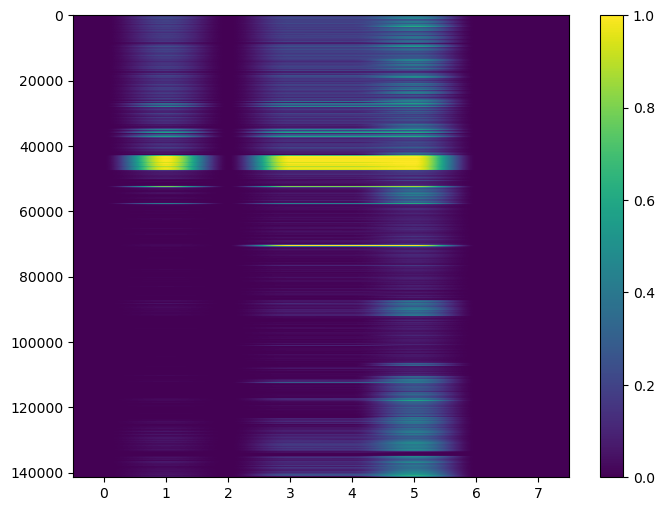

In [7]:
# missing values handle
missing_values = data1.isnull()          # missing value percent
print((missing_values.sum()/row1)*100)              # percentage 

# heatmap to visualize the missing data
plt.figure(figsize=(8, 6))
plt.imshow(missing_values, aspect='auto', cmap='viridis')
plt.colorbar()

In [8]:
# separating missing value columns with no missing value columns
missing = data1.columns[data1.isnull().any()]
no_missing = []
for i in data1.columns:
    if i not in missing:
        no_missing.append(i)
knn_data1 = data1[missing]

# Handling missing value with KNN and SimpleImputer
scaler = StandardScaler()
knn_data1 = pd.DataFrame(scaler.fit_transform(knn_data1))     #scaling the data first

# KNN
knn = KNNImputer(n_neighbors=5)
knn_data1 = pd.DataFrame(knn.fit_transform(knn_data1))

In [9]:
# scaling the non_missing columns
scaler = StandardScaler()
scale_data1 = pd.DataFrame(scaler.fit_transform(data1[no_missing]))
data1 = pd.concat([scale_data1, knn_data1], axis=1)

In [10]:
# rename all the columns again
data1.rename(columns=dict(zip(data1.columns, data1_feature)), inplace=True)
data1

,densityPercentSol,phValue,experimentalTechnique,macromoleculeType,densityPercentSol,phValue,experimentalTechnique,macromoleculeType
0,-0.376968,-0.185813,-0.774533,0.308056,-0.257859,-1.135926,-2.025149,0.082648
1,-0.375096,-0.183037,-2.474043,0.308056,-0.009786,-0.855219,-1.276969,0.215626
2,-0.314247,-0.165156,-0.208030,0.308056,-0.137367,0.535554,0.875533,0.864874
3,-0.375096,-0.183568,-2.474043,0.308056,-0.045225,-0.497956,-0.523841,0.082648
4,-0.309099,-0.163726,-0.208030,0.308056,-0.371264,0.101735,0.388622,-0.112909
...,...,...,...,...,...,...,...,...
141396,0.049908,-0.017998,-0.208030,0.308056,0.238287,-0.370363,-0.303148,-0.011219
141397,-0.386329,-0.154379,4.890499,0.308056,0.184420,0.637629,0.972519,-0.191131
141398,-0.226251,-0.136758,-0.208030,0.308056,-0.328737,-0.217250,-0.058703,-0.026864
141399,-0.204720,-0.120461,-0.208030,0.308056,-0.257859,0.152773,0.452949,-0.159842


In [12]:
# lebel encoding the classification column
# join the label column to the training data

label_encoder = LabelEncoder()
data1_label_encoded = label_encoder.fit_transform(data1_label)
data1_label_encoded = scaler.fit_transform(data1_label_encoded)
data1_label = pd.DataFrame(data1_label_encoded, columns=['label_column'])
data1_label

ValueError: Expected 2D array, got 1D array instead:
array=[1049.  965. 2750. ... 2067. 1948. 1948.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
'''
As there is 8 features, there is no need for feature selection
'''

'\nAs there is 8 features, there is no need for feature selection\n'

Dimensionality Reduction for Protein Sequence

In [ ]:
# Prcessing data2
# converting or encoding the sequence of protein sequence

data2_label = data2['sequence']
data2_index = data2['structureId']

def generate_kmers(sequence, k):
    if isinstance(sequence, str) and k > 0 and k <= len(sequence):
        return [sequence[x:x+k].upper() for x in range(len(sequence) - k + 1)]
    else:
        return []

k = 3        # kmer with 3 frequency
kmer_docs = [" ".join(generate_kmers(str(seq), k)) for seq in data2_label]
vectorizer = CountVectorizer()
data2_label = vectorizer.fit_transform(kmer_docs)


In [ ]:
# scaled the sparse matrix
scaler = StandardScaler()
data2_label = scaler.fit_transform(data2_label)
data2_label

  (0, 503)	2
  (0, 587)	2
  (0, 2342)	1
  (0, 2261)	1
  (0, 583)	1
  (0, 2257)	1
  (1, 503)	2
  (1, 587)	2
  (1, 2342)	1
  (1, 2261)	1
  (1, 583)	1
  (1, 2257)	1
  (2, 2261)	2
  (2, 583)	2
  (2, 582)	1
  (2, 2233)	1
  (2, 16)	1
  (2, 360)	1
  (2, 7413)	1
  (2, 7097)	1
  (3, 2261)	2
  (3, 583)	2
  (3, 582)	1
  (3, 2233)	1
  (3, 16)	1
  :	:
  (4, 285)	1
  (4, 5854)	1
  (4, 2243)	1
  (4, 227)	1
  (4, 4676)	1
  (4, 5038)	1
  (4, 3565)	1
  (4, 198)	1
  (4, 4065)	1
  (4, 1552)	1
  (4, 4091)	1
  (4, 2099)	1
  (4, 6350)	1
  (4, 3605)	1
  (4, 1065)	1
  (4, 3115)	1
  (4, 8)	1
  (4, 193)	1
  (4, 3978)	1
  (4, 9044)	1
  (4, 3628)	1
  (4, 1553)	1
  (4, 4118)	1
  (4, 2680)	1
  (4, 9151)	1


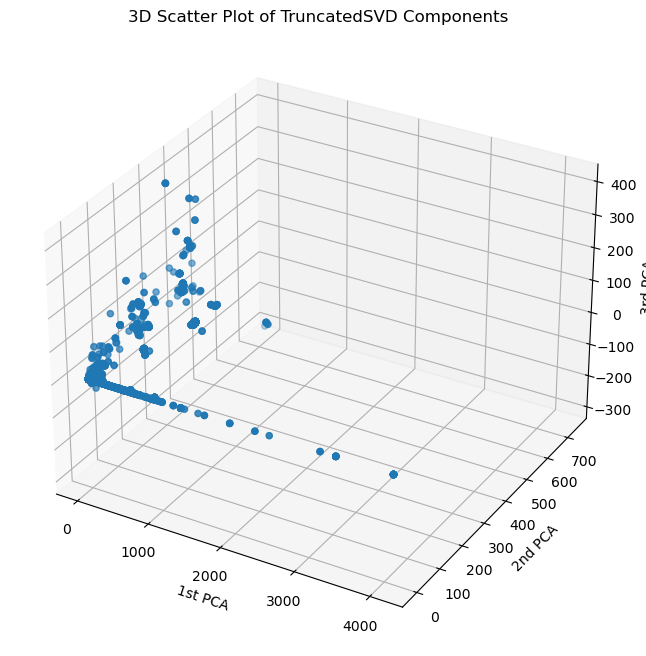

In [ ]:
# using TruncatedSVD to reduce the dimension of sparse matrix
# visualizing that in 3d scatter plot
# understanding the pattern of data_label as sparse matrix

svd = TruncatedSVD(n_components=100) 
data2_label_reduced = svd.fit_transform(data2_label)

# first three PCAs
pc1 = data2_label_reduced[:, 0]  # First principal component
pc2 = data2_label_reduced[:, 1]  # Second principal component
pc3 = data2_label_reduced[:, 2]  # Third principal component

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(pc1, pc2, pc3)
ax.set_xlabel('1st PCA')
ax.set_ylabel('2nd PCA')
ax.set_zlabel('3rd PCA')
ax.set_title('3D Scatter Plot of TruncatedSVD Components')
plt.show()

Predictive Model Building (Random Forest)

In [ ]:
# data split into train and test (20%)
data1_index = pd.DataFrame(data1_index)
data1 = data1_index.join(data1)             # join index with feature
data1_label = data1_index.join(data1_label)        # join index with label
data1_x_train, data1_x_test, data1_y_train, data1_y_test = train_test_split(data1, data1_label, test_size=0.2, random_state=42)     

# drop index from train and test and store them
# storing index of train test before dropping
data1_x_train_index = data1_x_train['structureId']
data1_x_test_index = data1_x_test['structureId']
data1_y_train_index = data1_y_train['structureId']
data1_y_test_index = data1_x_test['structureId']

data1_x_train = data1_x_train.drop(columns='structureId')
data1_x_test = data1_x_test.drop(columns='structureId')
data1_y_train = data1_y_train.drop(columns='structureId')
data1_y_test = data1_y_test.drop(columns='structureId')

In [ ]:
# Train Random Forest model 
rf = RandomForestClassifier()
rf.fit(data1_x_train, data1_y_train)

'\nrf = RandomForestClassifier()\nrf.fit(X_train, y_train)\nrf_predictions = rf.predict(X_test)\nf1 = f1_score(y_test, predictions)\nprint(f"F1 Score: {f1}")\n\n\nprobabilities = model.predict_proba(X_test)[:, 1]\nroc_auc = roc_auc_score(y_test, probabilities)\nprint(f"AUC-ROC: {roc_auc}")\n\nfpr, tpr, _ = roc_curve(y_test, probabilities)\nplt.plot(fpr, tpr, label=\'AUC = %0.2f\' % roc_auc)\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'Receiver Operating Characteristic\')\nplt.legend(loc="lower right")\nplt.show()\n'

In [ ]:
# f1 score and roc_suc score 
rf_predictions = rf.predict(data1_x_test)
rf_f1 = f1_score(data1_y_test, rf_predictions)
print(f"F1 Score: {rf_f1}")

rf_probabilities = rf.predict_proba(data1_x_test)[:, 1]
rf_roc_auc = roc_auc_score(data1_y_test, rf_probabilities)
print(f"AUC-ROC: {rf_roc_auc}")

In [ ]:
# visualize roc curve for overfitting and underfitting
fpr, tpr, _ = roc_curve(data1_y_test, rf_probabilities)
plt.plot(fpr, tpr, label='AUC = %0.2f' % rf_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Protein Sequence Prediction (Clusterings >> DBSCAN)

In [ ]:
# Using DBSCAN to predict the protein sequence 
dbscan = DBSCAN(eps=0.2, min_samples=1000)
clusters = dbscan.fit_predict(data2_label)

print("Cluster assignments:", clusters)

In [ ]:
# visualize the cluster in 2d scatter plot
# reduced the dimension 100 to 2-3
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(clusters)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], cmap='viridis', marker='o', s=20)
plt.colorbar()
plt.xlabel('t-SNE Dim1')
plt.ylabel('t-SNE Dim2')
plt.title('t-SNE Visualization of DBSCAN Clusters')
plt.show()

Protein Sequence Prediction (KNN)

Prediction